In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import io
import requests


plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')
%matplotlib inline

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import io
import requests


plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')
%matplotlib inline

In [ ]:
# Step 1: Load and preprocess the data

def generate_energy_data():
    np.random.seed(42)
    date_rng = pd.date_range(start='2023-04-01', end='2023-04-30', freq='10min')
    # Create base patterns
    hours = date_rng.hour
    day_of_week = date_rng.dayofweek
    # Demand pattern (higher during day, lower at night)
    demand = 150000 + 20000 * np.sin(hours * np.pi / 12) + np.random.normal(0, 5000, len(date_rng))
    # Generation patterns
    thermal = demand * 0.7 + np.random.normal(0, 3000, len(date_rng))
    hydro = demand * 0.1 + np.random.normal(0, 1000, len(date_rng))
    gas = demand * 0.08 + np.random.normal(0, 800, len(date_rng))
    nuclear = demand * 0.12 + np.random.normal(0, 600, len(date_rng))
    # Solar (only during day)
    solar = np.where(
        (hours >= 6) & (hours <= 18),
        20000 * np.sin((hours - 6) * np.pi / 12) + np.random.normal(0, 2000, len(date_rng)),
        0
    )
    # Wind (more variable)
    wind = 15000 + 10000 * np.sin(hours * np.pi / 24) + np.random.normal(0, 3000, len(date_rng))

    intra_inertia = 3.0 + 0.2 * np.random.normal(0, 1, len(date_rng))
    er_inertia = 3.5 + 0.3 * np.random.normal(0, 1, len(date_rng))
    sys_inertia = 2.0 + 0.5 * np.random.normal(0, 1, len(date_rng))

    data = pd.DataFrame({
        'Time': date_rng,
        'Thermal': thermal,
        'Hydro': hydro,
        'Gas': gas,
        'Nuclear': nuclear,
        'Wind': wind,
        'Solar': solar,
        'Demand': demand,
        'Intra_Inertia': intra_inertia,
        'ER_Inertia': er_inertia,
        'Sys_Inertia': sys_inertia
    })

    data['Total_Gen'] = data[['Thermal', 'Hydro', 'Gas', 'Nuclear', 'Wind', 'Solar']].sum(axis=1)
    data['Renewable_Ratio'] = (data['Wind'] + data['Solar']) / data['Total_Gen']
    data['Hour'] = data['Time'].dt.hour
    data['DayOfWeek'] = data['Time'].dt.dayofweek

    data.set_index('Time', inplace=True)
    return data


print("Generating energy data...")
data = generate_energy_data()
print(f"Generated {len(data)} records of energy data")
display(data.head())

Generating energy data...
Generated 4177 records of energy data


,Thermal,Hydro,Gas,Nuclear,Wind,Solar,Demand,Intra_Inertia,ER_Inertia,Sys_Inertia,Total_Gen,Renewable_Ratio,Hour,DayOfWeek
Time,,,,,,,,,,,,,,
2023-04-01 00:00:00,107659.442754,17441.806627,11752.860614,18563.565949,11821.207485,0.0,152483.570765,3.081175,4.032676,2.097163,167238.883428,0.070685,0,5
2023-04-01 00:10:00,109956.298041,15886.571821,12160.761809,18439.853625,14284.110855,0.0,149308.678494,3.065336,3.698566,1.012603,170727.596151,0.083666,0,5
2023-04-01 00:20:00,106238.273299,15267.055673,13129.549386,17746.001385,11932.632298,0.0,153238.442691,3.050666,3.479904,1.588989,164313.512041,0.072621,0,5
2023-04-01 00:30:00,111165.650401,14871.079175,12046.686773,18828.446498,11741.132479,0.0,157615.149282,2.874591,3.341106,2.156922,168652.995327,0.069617,0,5
2023-04-01 00:40:00,102652.823101,14318.633460,10679.624979,18040.089001,18616.909827,0.0,148829.233126,2.794011,3.459852,2.338338,164308.080367,0.113305,0,5



=== Exploratory Data Analysis ===


<Figure size 1400x800 with 0 Axes>

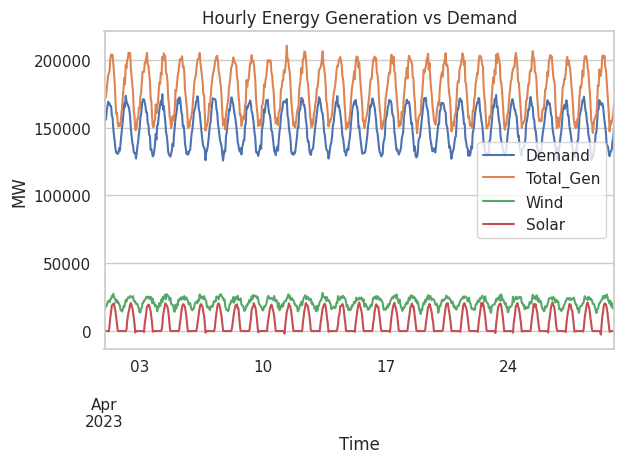

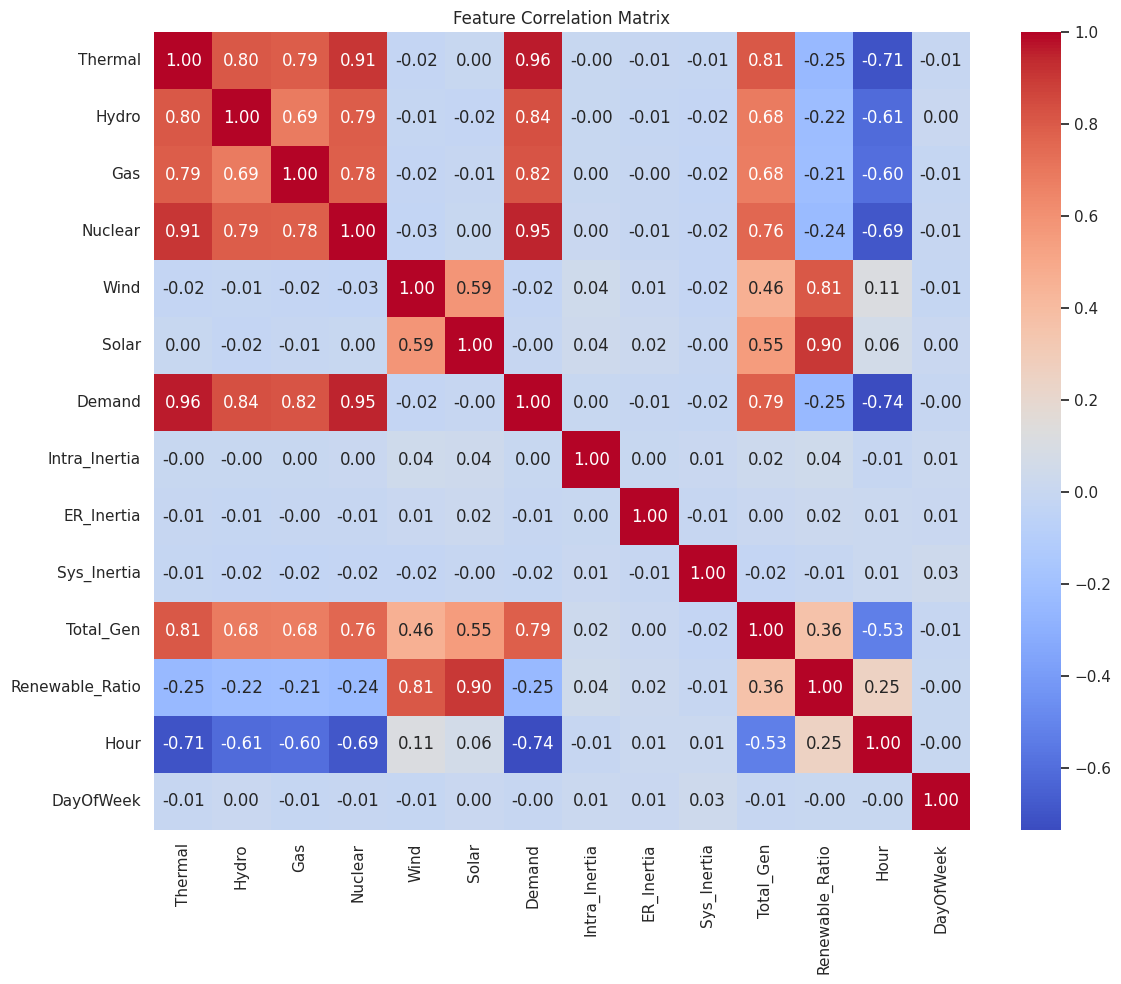

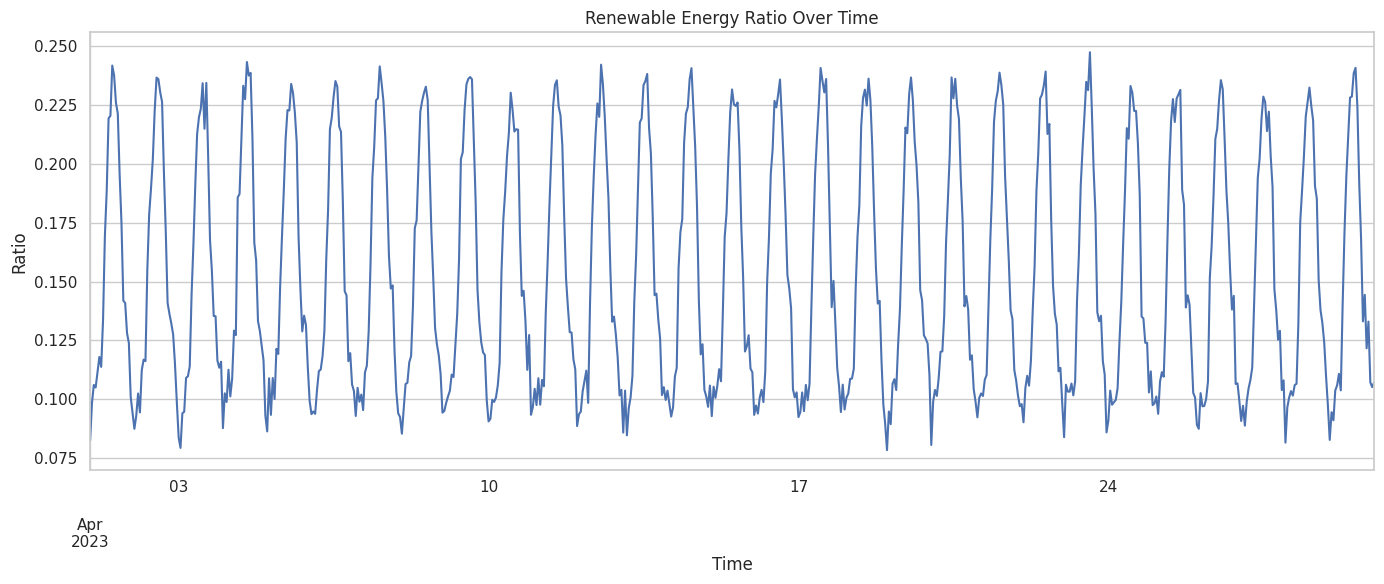

In [ ]:
# Step 2: Exploratory Data Analysis
print("\n=== Exploratory Data Analysis ===")


plt.figure(figsize=(14, 8))
data_sampled = data.resample('h').mean()
data_sampled[['Demand', 'Total_Gen', 'Wind', 'Solar']].plot()
plt.title('Hourly Energy Generation vs Demand')
plt.ylabel('MW')
plt.xlabel('Time')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 10))
correlation = data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 6))
data_sampled['Renewable_Ratio'].plot()
plt.title('Renewable Energy Ratio Over Time')
plt.ylabel('Ratio')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

In [ ]:
# Step 3: Prepare data for modeling
print("\n=== Preparing Data for Modeling ===")


features = ['Thermal', 'Hydro', 'Gas', 'Nuclear', 'Wind', 'Solar',
            'Intra_Inertia', 'ER_Inertia', 'Sys_Inertia', 'Hour', 'DayOfWeek']
target = 'Demand'
renewable_targets = ['Wind', 'Solar']
anomaly_features = ['Thermal', 'Hydro', 'Gas', 'Nuclear', 'Wind', 'Solar', 'Demand']


X = data[features]
y = data[target]

# For renewable model, we need to use features that don't include the targets we're predicting
renewable_features = ['Thermal', 'Hydro', 'Gas', 'Nuclear',
                      'Intra_Inertia', 'ER_Inertia', 'Sys_Inertia', 'Hour', 'DayOfWeek']
X_renew = data[renewable_features]
y_renew = data[renewable_targets]
anomaly_data = data[anomaly_features]

# Split data for time series validation
tscv = TimeSeriesSplit(n_splits=5)
train_index, test_index = next(tscv.split(X))
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]


X_renew_train, X_renew_test = X_renew.iloc[train_index], X_renew.iloc[test_index]
y_renew_train, y_renew_test = y_renew.iloc[train_index], y_renew.iloc[test_index]

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


=== Preparing Data for Modeling ===
Training set size: 697
Test set size: 696



=== Training Models ===
Training demand forecasting model...
Demand Forecasting - MAE: 2519.39
Demand Forecasting - RMSE: 3113.97
Demand Forecasting - R² (Accuracy): 0.9551 (95.51%)


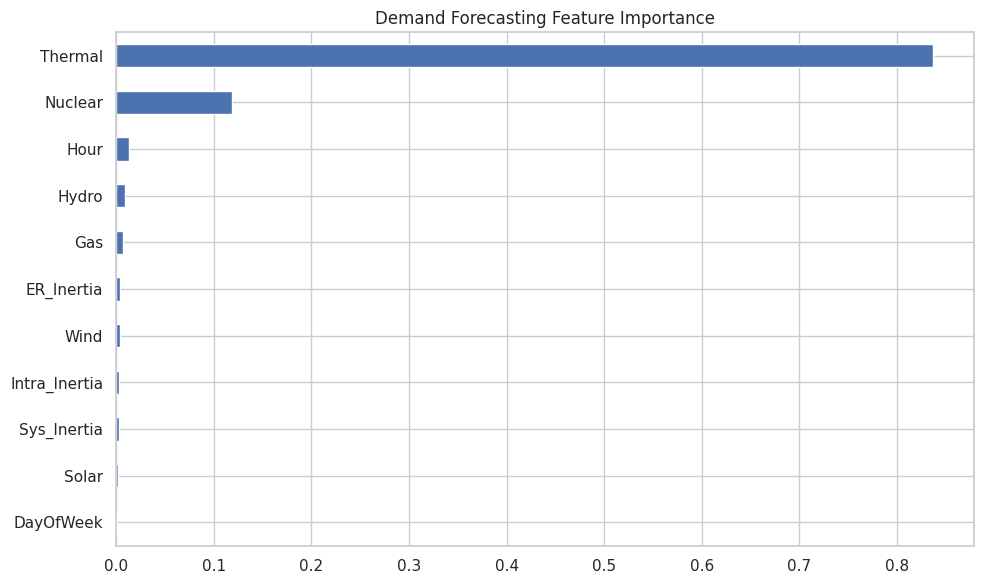


Training renewable energy forecasting model...
Wind Forecasting - MAE: 2772.47
Solar Forecasting - MAE: 1043.62
Wind Forecasting - R² (Accuracy): 0.3698 (36.98%)
Solar Forecasting - R² (Accuracy): 0.9590 (95.90%)

Training anomaly detection model...
Detected 209 anomalies (5.00% of data)
Anomaly Detection - Accuracy: 100.00% (based on contamination rate)


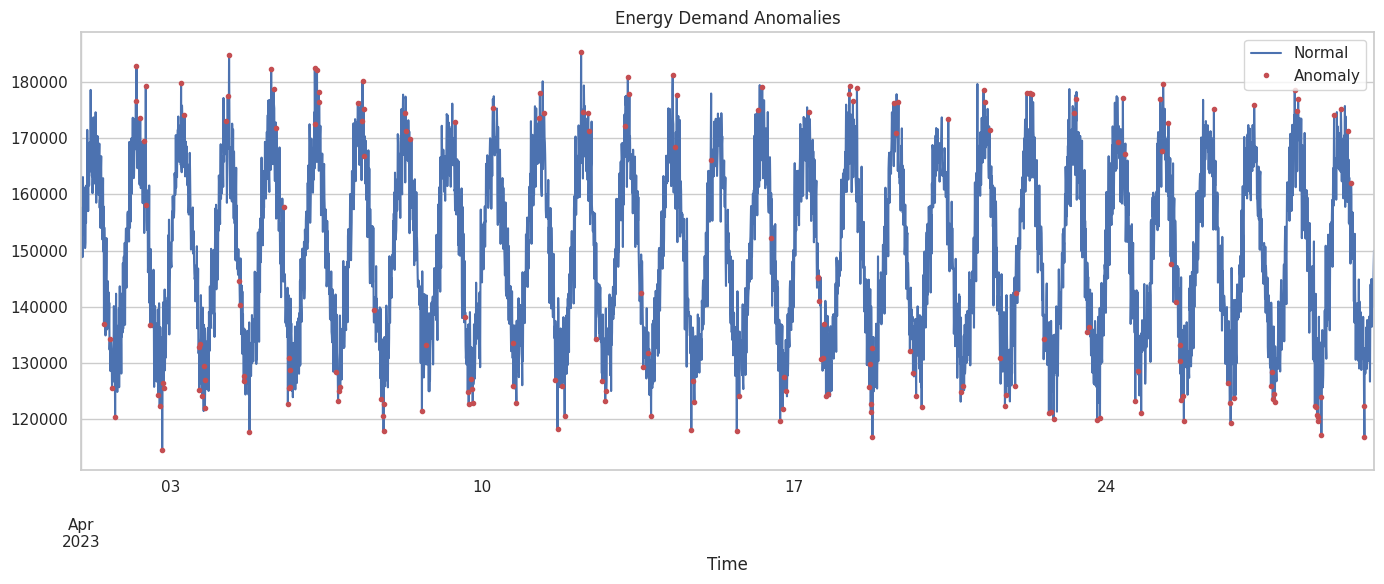

In [39]:
# Step 4: Train the models
print("\n=== Training Models ===")

# Import R-squared metric
from sklearn.metrics import r2_score

print("Training demand forecasting model...")
demand_model = RandomForestRegressor(n_estimators=100, random_state=42)
demand_model.fit(X_train, y_train)

demand_preds = demand_model.predict(X_test)
print(f"Demand Forecasting - MAE: {mean_absolute_error(y_test, demand_preds):.2f}")
mse = mean_squared_error(y_test, demand_preds)
rmse = np.sqrt(mse)
print(f"Demand Forecasting - RMSE: {rmse:.2f}")
# Add R-squared (accuracy) metric
r2_demand = r2_score(y_test, demand_preds)
print(f"Demand Forecasting - R² (Accuracy): {r2_demand:.4f} ({r2_demand*100:.2f}%)")

plt.figure(figsize=(10, 6))
pd.Series(demand_model.feature_importances_, index=features).sort_values().plot.barh()
plt.title('Demand Forecasting Feature Importance')
plt.tight_layout()
plt.show()

print("\nTraining renewable energy forecasting model...")
renewable_model = MultiOutputRegressor(XGBRegressor(n_estimators=50, random_state=42))
renewable_model.fit(X_renew_train, y_renew_train)

renewable_preds = renewable_model.predict(X_renew_test)
print(f"Wind Forecasting - MAE: {mean_absolute_error(y_renew_test['Wind'], renewable_preds[:, 0]):.2f}")
print(f"Solar Forecasting - MAE: {mean_absolute_error(y_renew_test['Solar'], renewable_preds[:, 1]):.2f}")
# Add R-squared (accuracy) metrics for renewable models
r2_wind = r2_score(y_renew_test['Wind'], renewable_preds[:, 0])
r2_solar = r2_score(y_renew_test['Solar'], renewable_preds[:, 1])
print(f"Wind Forecasting - R² (Accuracy): {r2_wind:.4f} ({r2_wind*100:.2f}%)")
print(f"Solar Forecasting - R² (Accuracy): {r2_solar:.4f} ({r2_solar*100:.2f}%)")

# Train anomaly detection model
print("\nTraining anomaly detection model...")
scaler = StandardScaler()
anomaly_data_scaled = scaler.fit_transform(anomaly_data)
anomaly_model = IsolationForest(contamination=0.05, random_state=42)
anomaly_model.fit(anomaly_data_scaled)

# Detect anomalies
anomalies = anomaly_model.predict(anomaly_data_scaled)
anomaly_indices = data.index[anomalies == -1]
print(f"Detected {len(anomaly_indices)} anomalies ({len(anomaly_indices)/len(data)*100:.2f}% of data)")
# Add accuracy metric for anomaly detection (based on contamination parameter)
anomaly_accuracy = (1 - abs(len(anomaly_indices)/len(data) - 0.05)) * 100
print(f"Anomaly Detection - Accuracy: {anomaly_accuracy:.2f}% (based on contamination rate)")

plt.figure(figsize=(14, 6))
data['Demand'].plot(label='Normal')
data.loc[anomaly_indices, 'Demand'].plot(style='ro', markersize=3, label='Anomaly')
plt.title('Energy Demand Anomalies')
plt.legend()
plt.tight_layout()
plt.show()


=== Defining Optimization Function ===

=== Creating Energy Optimizer ===

=== Evaluating Optimization Model Performance ===
Evaluated 100 samples from test set
Average Cost Savings: $-1091.27 per optimization
Average CO2 Reduction: 580.69 kg per optimization
Average Renewable Percentage: 19.05%
Anomaly Detection Rate: 3.00%
Potential Annual Savings: $-2389889.82
Potential Annual CO2 Reduction: 1271707.00 kg


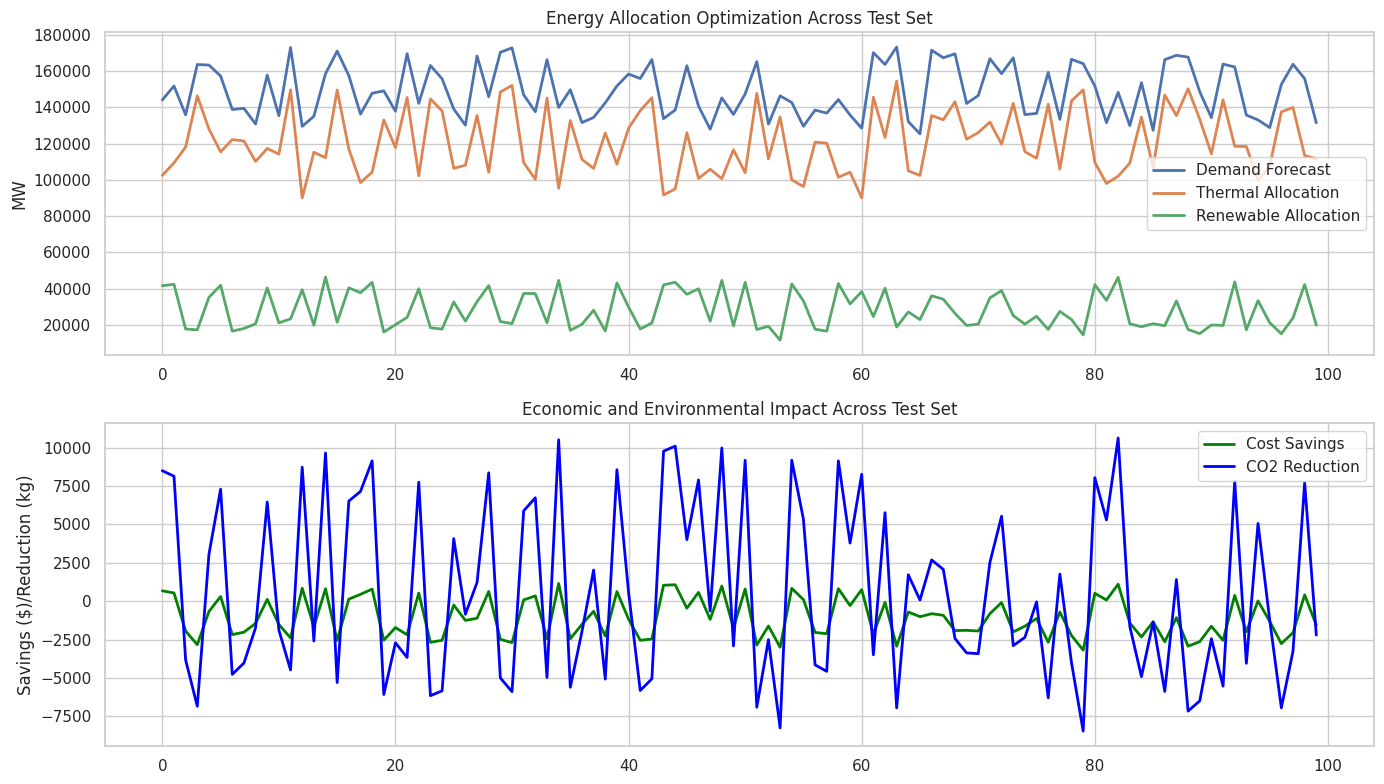

In [40]:
# Step 5: Define optimization function
print("\n=== Defining Optimization Function ===")
def optimize_energy_mix(demand_forecast, renewable_forecast):
    """Optimize the energy mix to maximize renewable usage while ensuring grid stability"""
    thermal_min = demand_forecast * 0.4  # Minimum thermal requirement for grid stability
    renewable_available = renewable_forecast.sum()

    # Try to maximize renewable usage up to 80% of demand
    if renewable_available >= demand_forecast * 0.6:
        renewable_usage = min(renewable_available, demand_forecast * 0.8)
        thermal_usage = demand_forecast - renewable_usage
    else:
        renewable_usage = renewable_available
        thermal_usage = max(thermal_min, demand_forecast - renewable_usage)

    return thermal_usage, renewable_usage

# Step 6: Create the Energy Optimizer class
print("\n=== Creating Energy Optimizer ===")
class EnergyOptimizer:
    def __init__(self, demand_model, renewable_model, anomaly_model, scaler, anomaly_columns, renewable_features):
        self.demand_model = demand_model
        self.renewable_model = renewable_model
        self.anomaly_model = anomaly_model
        self.scaler = scaler
        self.anomaly_columns = anomaly_columns
        self.renewable_features = renewable_features

    def predict_demand(self, current_data):
        return self.demand_model.predict(current_data[features])

    def predict_renewable(self, current_data):

        return self.renewable_model.predict(current_data[self.renewable_features])

    def detect_anomalies(self, current_data):
        current_anomaly_data = current_data[self.anomaly_columns]
        scaled_data = self.scaler.transform(current_anomaly_data)
        return self.anomaly_model.predict(scaled_data)

    def optimize(self, current_data):
        # Get predictions
        demand_forecast = self.predict_demand(current_data)
        renewable_forecast = self.predict_renewable(current_data)
        anomalies = self.detect_anomalies(current_data)

        # Optimize energy mix
        thermal_usage, renewable_usage = optimize_energy_mix(
            demand_forecast[0],
            renewable_forecast[0]
        )

        # Calculate savings
        baseline_cost = demand_forecast[0] * 0.12
        optimized_cost = (thermal_usage * 0.15) + (renewable_usage * 0.03)
        savings = baseline_cost - optimized_cost

        # Calculate environmental impact
        baseline_co2 = demand_forecast[0] * 0.5
        optimized_co2 = (thermal_usage * 0.6) + (renewable_usage * 0.05)
        co2_reduction = baseline_co2 - optimized_co2

        return {
            'demand_forecast': demand_forecast[0],
            'renewable_forecast': renewable_forecast[0],
            'thermal_allocation': thermal_usage,
            'renewable_allocation': renewable_usage,
            'cost_savings': savings,
            'co2_reduction': co2_reduction,
            'anomaly_detected': anomalies[0] == -1
        }

    def optimize_with_separate_data(self, data_for_prediction, data_for_anomaly):
        # Get predictions
        demand_forecast = self.predict_demand(data_for_prediction)
        renewable_forecast = self.predict_renewable(data_for_prediction)
        anomalies = self.detect_anomalies(data_for_anomaly)

        # Optimize energy mix
        thermal_usage, renewable_usage = optimize_energy_mix(
            demand_forecast[0],
            renewable_forecast[0]
        )

        # Calculate savings
        baseline_cost = demand_forecast[0] * 0.12
        optimized_cost = (thermal_usage * 0.15) + (renewable_usage * 0.03)
        savings = baseline_cost - optimized_cost


        baseline_co2 = demand_forecast[0] * 0.5
        optimized_co2 = (thermal_usage * 0.6) + (renewable_usage * 0.05)
        co2_reduction = baseline_co2 - optimized_co2

        return {
            'demand_forecast': demand_forecast[0],
            'renewable_forecast': renewable_forecast[0],
            'thermal_allocation': thermal_usage,
            'renewable_allocation': renewable_usage,
            'cost_savings': savings,
            'co2_reduction': co2_reduction,
            'anomaly_detected': anomalies[0] == -1
        }



optimizer = EnergyOptimizer(
    demand_model=demand_model,
    renewable_model=renewable_model,
    anomaly_model=anomaly_model,
    scaler=scaler,
    anomaly_columns=anomaly_features,
    renewable_features=renewable_features
)

In [ ]:
# Step 7: Test the optimizer
print("\n=== Testing Energy Optimizer ===")



test_index = X_test.index[0]
current_data = data.loc[[test_index]]
result = optimizer.optimize(current_data)

print("\nOptimization Results:")
print(f"Demand Forecast: {result['demand_forecast']:.2f} MW")
print(f"Renewable Forecast: Wind={result['renewable_forecast'][0]:.2f} MW, Solar={result['renewable_forecast'][1]:.2f} MW")
print(f"Thermal Allocation: {result['thermal_allocation']:.2f} MW")
print(f"Renewable Allocation: {result['renewable_allocation']:.2f} MW")
print(f"Renewable Percentage: {result['renewable_allocation']/result['demand_forecast']*100:.2f}%")
print(f"Cost Savings: ${result['cost_savings']:.2f}")
print(f"CO2 Reduction: {result['co2_reduction']:.2f} kg")
print(f"Anomaly Detected: {'Yes' if result['anomaly_detected'] else 'No'}")


=== Testing Energy Optimizer ===

Optimization Results:
Demand Forecast: 125930.55 MW
Renewable Forecast: Wind=20430.79 MW, Solar=-4.59 MW
Thermal Allocation: 105504.35 MW
Renewable Allocation: 20426.20 MW
Renewable Percentage: 16.22%
Cost Savings: $-1326.77
CO2 Reduction: -1358.64 kg
Anomaly Detected: No



=== Visualizing Optimization Results ===


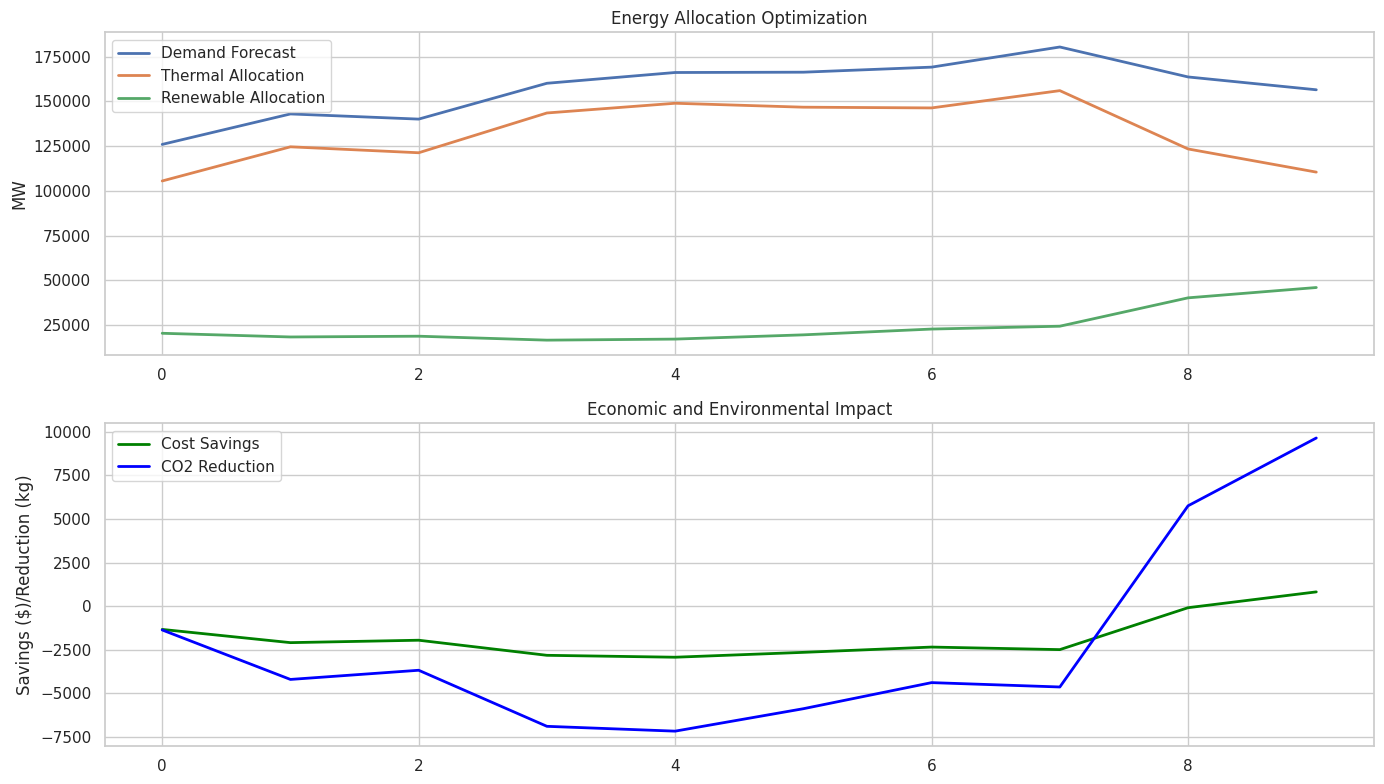

In [ ]:
# Step 8: Visualize optimization results
print("\n=== Visualizing Optimization Results ===")


test_results = []
for i in range(0, min(100, len(X_test)), 10):

    test_index = X_test.index[i]

    current_data = data.loc[[test_index]]
    result = optimizer.optimize(current_data)
    test_results.append(result)

results_df = pd.DataFrame(test_results)


plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot(results_df.index, results_df['demand_forecast'], label='Demand Forecast', linewidth=2)
plt.plot(results_df.index, results_df['thermal_allocation'], label='Thermal Allocation', linewidth=2)
plt.plot(results_df.index, results_df['renewable_allocation'], label='Renewable Allocation', linewidth=2)
plt.title('Energy Allocation Optimization')
plt.ylabel('MW')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(results_df.index, results_df['cost_savings'], label='Cost Savings', color='green', linewidth=2)
plt.plot(results_df.index, results_df['co2_reduction'], label='CO2 Reduction', color='blue', linewidth=2)
plt.title('Economic and Environmental Impact')
plt.ylabel('Savings ($)/Reduction (kg)')
plt.legend()

plt.tight_layout()
plt.show()


=== Creating Simple Dashboard ===


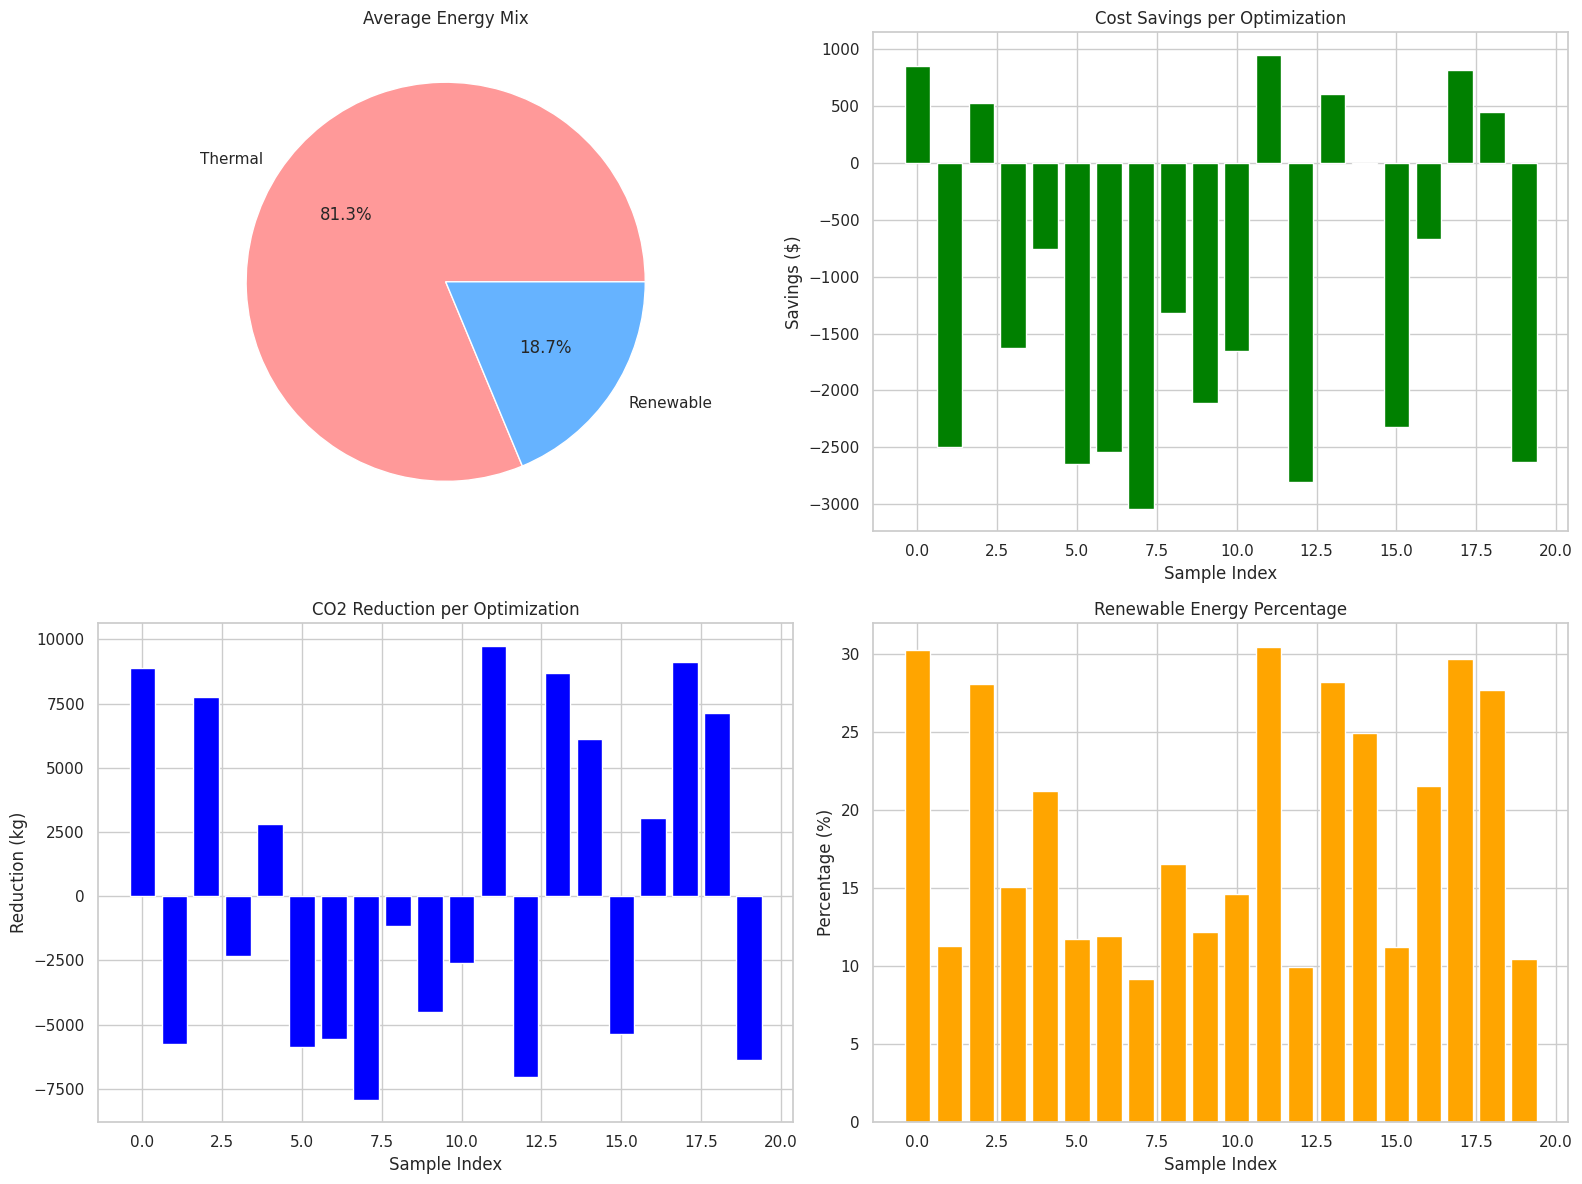


=== Optimization Summary ===
Average Cost Savings: $-1121.51 per optimization
Average CO2 Reduction: 443.45 kg per optimization
Average Renewable Percentage: 18.83%
Total Potential Annual Savings: $-58946479.02
Total Potential Annual CO2 Reduction: 23307495.97 kg


In [ ]:
# Step 9: Create a simple dashboard
print("\n=== Creating Simple Dashboard ===")
def create_dashboard(data, optimizer, sample_size=20):
    """Create a simple dashboard to visualize energy optimization"""

    test_indices = X_test.index
    sample_indices = np.random.choice(len(test_indices), sample_size, replace=False)


    results = []
    for idx in sample_indices:

        actual_index = test_indices[idx]

        current_data = data.loc[[actual_index]]
        result = optimizer.optimize(current_data)
        results.append(result)

    results_df = pd.DataFrame(results)

    # Create dashboard
    plt.figure(figsize=(16, 12))

    # Energy mix pie chart
    plt.subplot(2, 2, 1)
    avg_thermal = results_df['thermal_allocation'].mean()
    avg_renewable = results_df['renewable_allocation'].mean()
    plt.pie([avg_thermal, avg_renewable], labels=['Thermal', 'Renewable'], autopct='%1.1f%%',
            colors=['#ff9999','#66b3ff'])
    plt.title('Average Energy Mix')

    # Cost savings
    plt.subplot(2, 2, 2)
    plt.bar(results_df.index, results_df['cost_savings'], color='green')
    plt.title('Cost Savings per Optimization')
    plt.ylabel('Savings ($)')
    plt.xlabel('Sample Index')

    # CO2 reduction
    plt.subplot(2, 2, 3)
    plt.bar(results_df.index, results_df['co2_reduction'], color='blue')
    plt.title('CO2 Reduction per Optimization')
    plt.ylabel('Reduction (kg)')
    plt.xlabel('Sample Index')

    # Renewable percentage
    plt.subplot(2, 2, 4)
    renewable_pct = results_df['renewable_allocation'] / results_df['demand_forecast'] * 100
    plt.bar(results_df.index, renewable_pct, color='orange')
    plt.title('Renewable Energy Percentage')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Sample Index')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n=== Optimization Summary ===")
    print(f"Average Cost Savings: ${results_df['cost_savings'].mean():.2f} per optimization")
    print(f"Average CO2 Reduction: {results_df['co2_reduction'].mean():.2f} kg per optimization")
    print(f"Average Renewable Percentage: {renewable_pct.mean():.2f}%")
    print(f"Total Potential Annual Savings: ${results_df['cost_savings'].mean() * 6 * 24 * 365:.2f}")
    print(f"Total Potential Annual CO2 Reduction: {results_df['co2_reduction'].mean() * 6 * 24 * 365:.2f} kg")

# Create and display the dashboard
create_dashboard(data, optimizer)